In [55]:
import matplotlib.pyplot as plt
%matplotlib widget

In [56]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb
from stompy.grid import unstructured_grid
from matplotlib import colors
import pandas as pd
import os
import numpy as np
import xarray as xr
import subprocess
from scipy.integrate import solve_ivp
from numba import njit

from IPython.display import Video
import time
import six
import datetime
import glob
from stompy.plot import nbviz

In [57]:
# These online-coupled dfm-dwaq runs.

# Spinup
#run_dir="bloom_tracers_v01/run_20220801T0000_20220804T0000_v01"
# Main run
run_dir="bloom_tracers_v01/run_20220804T0000_20220830T0000_v00"

model=dfm.DFlowModel.load(run_dir)

In [58]:
ds=model.map_dataset()

In [59]:
grid=ds.grid
#()unstructured_grid.UnstructuredGrid.read_ugrid(ds)
#from stompy.plot import plot_wkb
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


In [60]:
def ratio(a,b,b_min=1e-8):
    return a/b.clip(b_min) * np.where(b<b_min,np.nan, 1.0)

In [61]:
frac=0.1
M=grid.smooth_matrix()
def fill(values,iterations=50):
    valid=np.isfinite(values)
    data=np.where(valid,values,0.0)
    weight=np.where(valid,1,0.0)
    for _ in range(iterations):
        data=M.dot(data)
        weight=M.dot(weight)
        data[valid]=values[valid]
        weight[valid]=1.0
    result=np.full(len(values),np.nan)
    valid=weight>1e-4
    result[valid]=data[valid]/weight[valid]
    return result

INFO:utils:82491/86633


Checking swim results
--

Looks like setting swimming via DFM is working, and the age/depth/radiation tracers
give reasonable results.

/tmp/ipykernel_464070/1365393542.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colls.append( ax.pcolormesh( conc.time, z, conc.values.T, cmap='turbo', shading='nearest') )


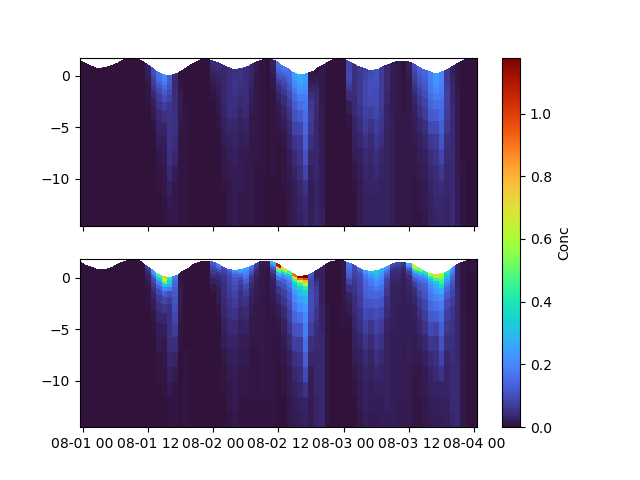

In [42]:
# Check to see whether upward swimming is working, and if age/property tracers are working.
point=[557240,4185530] # SE of Treasure Island.
c=ds.grid.select_cells_nearest(point)

conc0_tz = ds['conc0'].isel(nFlowElem=c)
conc1_tz = ds['conc1'].isel(nFlowElem=c)
z=-ds['FlowElem_zcc'].isel(nFlowElem=c) + ds['LayCoord_cc'] * ds['waterdepth'].isel(nFlowElem=c)

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
colls=[]
for ax,conc in zip(axs,[conc0_tz,conc1_tz]):
    colls.append( ax.pcolormesh( conc.time, z, conc.values.T, cmap='turbo', shading='nearest') )
colls[0].set_clim( colls[1].get_clim() )
plt.colorbar( colls[0], ax=axs, label="Conc")

/tmp/ipykernel_464070/2008385549.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colls.append( ax.pcolormesh( ds.time, z, age.values.T, cmap='turbo', shading='nearest') )


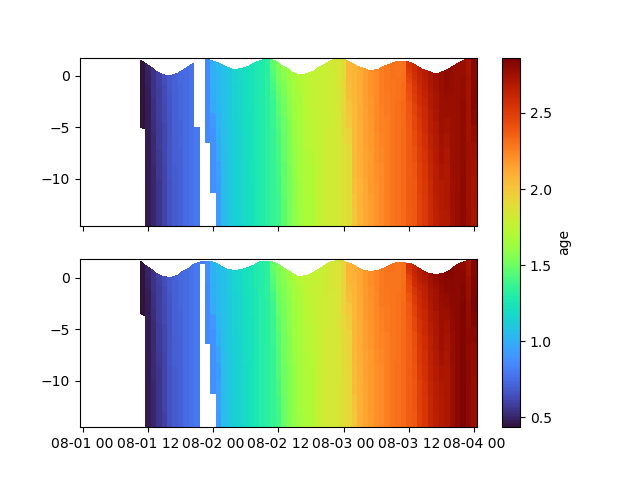

In [43]:
# Similar, but check on age. Looks okay.
agec0 = ds['agec0'].isel(nFlowElem=c)
agec1 = ds['agec1'].isel(nFlowElem=c)

age0=ratio(agec0, conc0_tz, 1e-5)
age1=ratio(agec1, conc1_tz, 1e-5)

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
colls=[]
for ax,age in zip(axs,[age0,age1]):
    colls.append( ax.pcolormesh( ds.time, z, age.values.T, cmap='turbo', shading='nearest') )
colls[0].set_clim( colls[1].get_clim() )
plt.colorbar( colls[0], ax=axs, label="age")

/tmp/ipykernel_464070/4273204357.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colls.append( ax.pcolormesh( ds.time, z, rad.values.T, cmap='turbo', shading='nearest') )


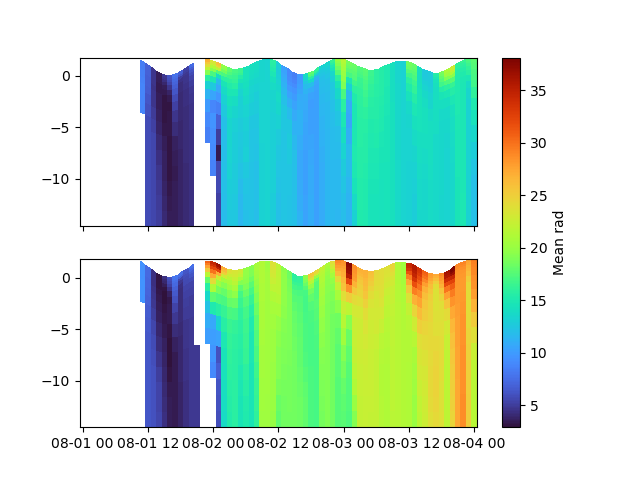

In [44]:
# Similar, but check on rad.
radc0 = ds['radc0'].isel(nFlowElem=c)
radc1 = ds['radc1'].isel(nFlowElem=c)

rad0=ratio(radc0, agec0, 1e-5)
rad1=ratio(radc1, agec1, 1e-5)

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
colls=[]
for ax,rad in zip(axs,[rad0,rad1]):
    colls.append( ax.pcolormesh( ds.time, z, rad.values.T, cmap='turbo', shading='nearest') )
colls[0].set_clim( colls[1].get_clim() )
plt.colorbar( colls[0], ax=axs, label="Mean rad")

/tmp/ipykernel_464070/2362719050.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colls.append( ax.pcolormesh( ds.time, z, dep.values.T, cmap='turbo', shading='nearest') )


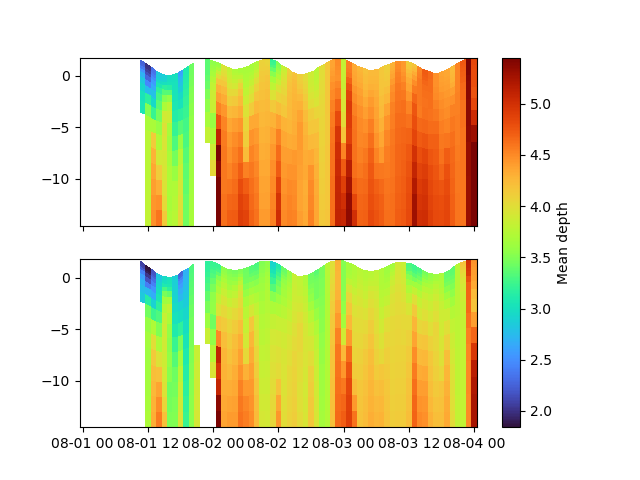

In [45]:
# Lastly, mean depth
depc0 = ds['depc0'].isel(nFlowElem=c)
depc1 = ds['depc1'].isel(nFlowElem=c)

dep0=ratio(depc0, agec0, 1e-5)
dep1=ratio(depc1, agec1, 1e-5)

fig,axs=plt.subplots(2,1,sharex=True,sharey=True)
colls=[]
for ax,dep in zip(axs,[dep0,dep1]):
    colls.append( ax.pcolormesh( ds.time, z, dep.values.T, cmap='turbo', shading='nearest') )
colls[0].set_clim( colls[1].get_clim() )
plt.colorbar( colls[0], ax=axs, label="Mean depth")

Plotting All Fields
--

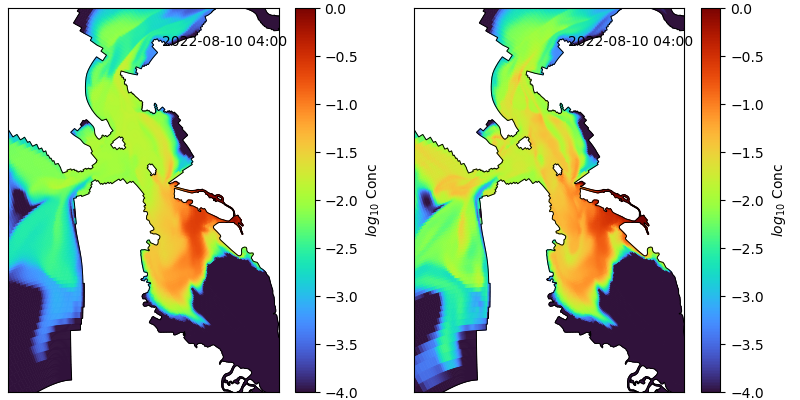

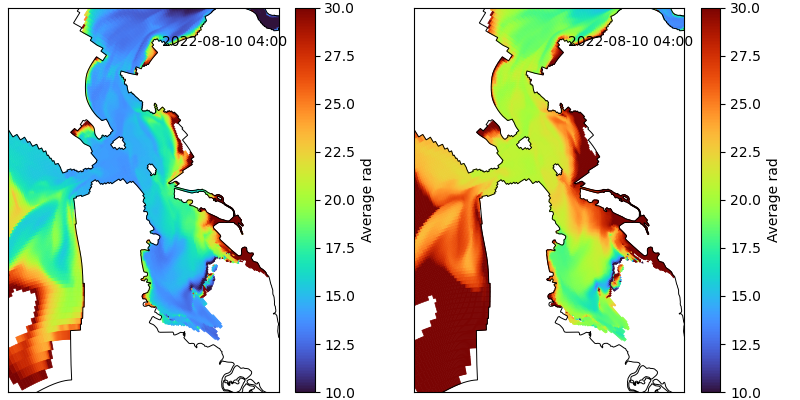

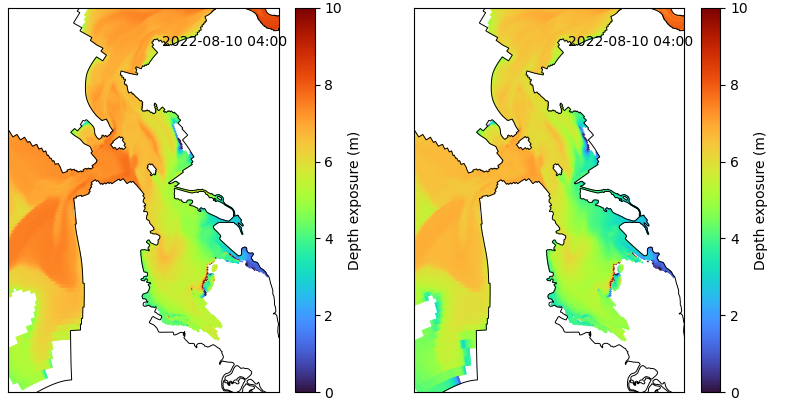

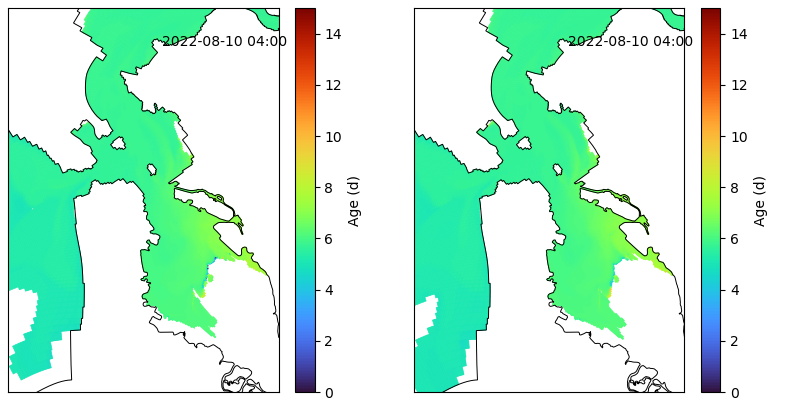

In [62]:
tidx=-1

plots=[
    #dict(label='Conc', clim=[0,1], data_fn=lambda snap: snap['conc0']),
    dict(label='$log_{10}$ Conc', clim=[-4,0], data_fn=lambda snap,g: np.log10(snap[f'conc{g}'].values.clip(1e-4))),
    dict(label='Average rad', clim=[10,30],data_fn=lambda snap,g: ratio( snap[f'radc{g}'].values, snap[f'agec{g}'].values, 1e-5)),
    dict(label="Depth exposure (m)", clim=[0,10], data_fn=lambda snap,g: ratio(snap[f'depc{g}'].values, snap[f'agec{g}'].values,1e-5)),    
    dict(label="Age (d)", clim=[0,15], data_fn=lambda snap,g: ratio(snap[f'agec{g}'].values, snap[f'conc{g}'].values,1e-5)),         
]

snap2d=ds.isel(time=tidx,laydim=-1)

for plot in plots: 
    fig,axs=plt.subplots(1,2,figsize=(8,4))
    for g,ax in enumerate(axs):
        ax.set_adjustable('datalim')
        fig.subplots_adjust(left=0.01, right=0.94, top=0.98, bottom=0.02)
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)    
        kw=dict(lw=0.5,edgecolor='face', cmap='turbo')    
        scal=plot['data_fn'](snap2d,g) 
                
        ccoll=ds.grid.plot_cells( values=scal, clim=plot['clim'], ax=ax, **kw)
        plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
        plt.colorbar(ccoll,label=plot['label'],ax=ax)
        ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
        ax.text(0.57,0.9, utils.strftime(snap2d.time.values), transform=ax.transAxes)

In [74]:
from stompy import memoize

@memoize.memoize(lru=1)
def extract_tracers(tidx,layer,Isat=10.0,thresh=1e-5,group=0):
    # Extraction
    # instantaneous release, so age is a given.
    t=ds.time.isel(time=tidx).values
    age_d = (t - ds.time.values[0]) / np.timedelta64(86400,'s')
    
    if layer=='mean':
        snap=ds.isel(time=tidx)
        conc = snap[f'conc{group}'].values.mean(axis=1).clip(0,np.inf)

        # These should be about the same, not sure why one would be preferable over the
        # other.
        #Imean =  ratio( snap['radc0'].values, snap['agec0'].values, thresh)
        Imean = ratio( snap[f'radc{group}'].values, snap[f'conc{group}'].values*age_d, thresh)
            
        kLight = (Imean/(Imean + Isat)).mean(axis=1) # happen to know that layer is the second dimension    
    else:
        snap=ds.isel(time=tidx,laydim=layer)
        conc  = snap[f'conc{group}'].values
    
        # average irradiance accounting for Kd, vertical mixing.
        Imean = ratio( snap[f'radc{group}'].values, snap[f'agec{group}'].values, thresh)
        # This could be averaged over the layers instead.
        kLight = Imean/(Imean + Isat)

    Imean[np.isnan(Imean)]=0.0 
    kLight = fill(kLight, iterations=120)
    return dict(age_d=age_d, conc=conc, kLight=kLight, Imean=Imean, t=t)  


In [64]:
sample_xy = [561890, 4173260]
sample_c=ds.grid.select_cells_nearest(sample_xy) # 24893

In [93]:
# Panel for P and a panel for N.

def solveNP(thresh=1e-5,
            # Parameters:
            c0 = 50,
            tidx = 20, 
            Isat=20., 
            N0=35, # initial DIN
            Nsat=0.5,
            kprod=0.7, # per day. high!
            kmort=0.1,
            alpha=0.15, # stoichiometry, uM DIN per ug/l chl production.
            layer='mean',
            group=0):
    tracers=extract_tracers(tidx=tidx, layer=layer, Isat=Isat,thresh=thresh,group=group)
    kLight = tracers['kLight']
    conc = c0*tracers['conc']
    age_d = tracers['age_d']
    Imean = tracers['Imean']
    t = tracers['t']

    sel = np.isfinite(kLight * conc * age_d)
    kLight = kLight[sel]
        
    # ODE integration
    # State vector is [ P[0].... P[i], N[0], ... , N[i] ]
    def diff(t,state):
        P,N=state.reshape([2,-1])
        N=N.clip(0) # no evidence this is really necessary
        P=P.clip(0) # likewise.
        kDIN=N/(N+Nsat)
        dgrossP = kprod*kLight*kDIN*P
        dnetP = -kmort*P + dgrossP
        dN = -alpha*dgrossP
        mu_net = kprod*kLight*kDIN - kmort
        return np.r_[dnetP,dN]
    IC=np.r_[conc[sel], N0*np.ones_like(conc)[sel]]

    print("IC shape: ", IC.shape) # 2*Ncells
    
    # odeint was buggy.
    #result = odeint(diff, IC, [0,age_d], hmax=0.1)
    bunch = solve_ivp(diff, y0=IC, t_span=[0,age_d])
    result=bunch.y[:,-1]
    Psel,Nsel = result.reshape([2,-1])
    # expand
    P = np.full(conc.shape,0.0)
    N = np.full(conc.shape,N0)
    P[sel]=Psel
    N[sel]=Nsel
    
    ds=xr.Dataset()
    ds['N'] = ('cell',), N
    ds['P'] = ('cell',), P
    ds['time'] = (),t
    return ds

IC shape:  (50380,)
IC shape:  (50532,)


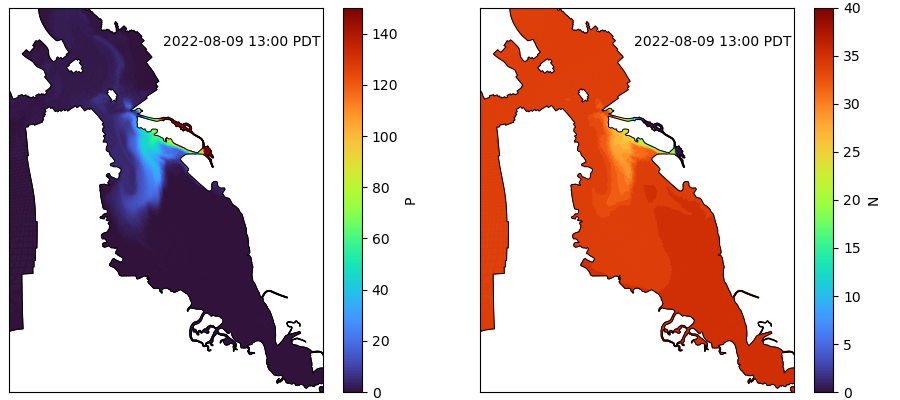

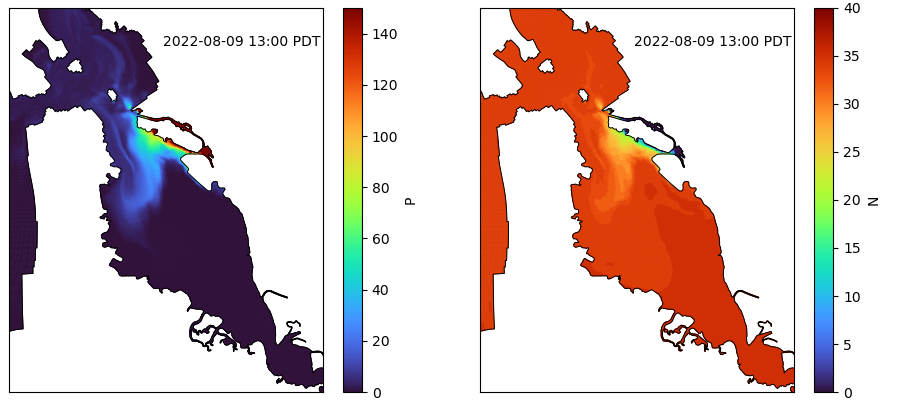

In [105]:
import matplotlib.colorbar as cbar

for group in [0,1]:
    result = solveNP(tidx=140,group=group,layer=9)
    
    fig,axs=plt.subplots(1,2,figsize=(9,4))
    fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
    axP,axN = axs
    caxs=[cbar.make_axes(ax)[0] for ax in axs]
    
    kw=dict(lw=0.5,edgecolor='face', cmap='turbo')
    
    for ax,cax,plot in zip(axs,caxs,[
        dict(scal=result.P,label='P',clim=[0,150]),
        dict(scal=result.N,label='N',clim=[0,40])
    ]):
        ax.set_adjustable('datalim')
        ax.xaxis.set_visible(0)
        ax.yaxis.set_visible(0)    
        ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax,**kw)
        ccoll.set_clim(plot['clim'])
        plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
        plt.colorbar(ccoll,label=plot['label'],cax=cax)
        # ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
        ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))
        ax.text(0.49,0.9, utils.strftime(result.time-np.timedelta64(7,'h'))+" PDT",
                transform=ax.transAxes)

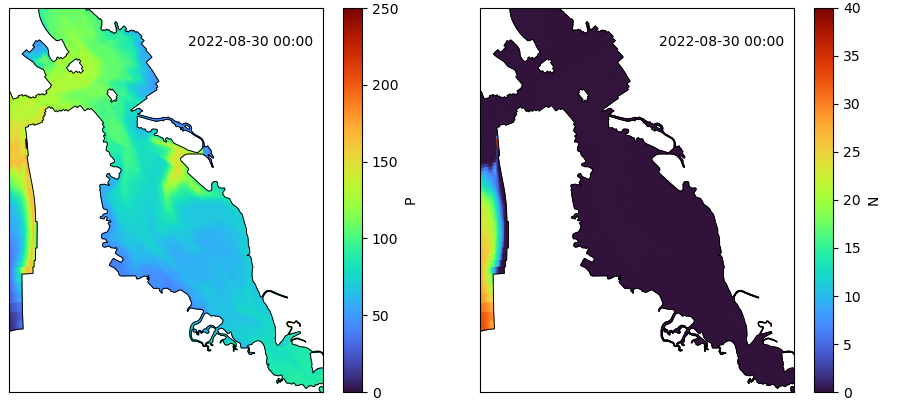

In [298]:
# Animation
fig,axs=plt.subplots(1,2,figsize=(9,4))
fig.subplots_adjust(left=0.01, right=0.97, top=0.98, bottom=0.02)
axP,axN = axs
caxs=[cbar.make_axes(ax)[0] for ax in axs]

frame_dir=os.path.join(run_dir,"frames_v00")
if not os.path.exists(frame_dir):
    os.makedirs(frame_dir)

for ax in axs:
    ax.set_adjustable('datalim')
    ax.xaxis.set_visible(0)
    ax.yaxis.set_visible(0)    

for tidx in range(ds.dims['time']):
    result = solveNP(tidx=tidx)

    axP.cla()
    axN.cla()
    
    
    kw=dict(lw=0.5,edgecolor='face', cmap='turbo')
    
    for ax,cax,plot in zip(axs,caxs,[
        dict(scal=result.P,label='P',clim=[0,250]),
        dict(scal=result.N,label='N',clim=[0,40])
    ]):
        ax.cla()
        cax.cla()
        
        ccoll=ds.grid.plot_cells( values=plot['scal'], ax=ax,**kw)
        ccoll.set_clim(plot['clim'])
        plot_wkb.plot_wkb(grid_poly,ec='k',fc='none',lw=0.7,ax=ax)
        plt.colorbar(ccoll,label=plot['label'],cax=cax)
        # ax.axis((532541.1781775085, 575394.0337062994, 4160999.923094737, 4202393.6312130485))
        ax.axis((540604.0430344798, 585428.0850690929, 4144192.2487012795, 4198977.188965806))
        ax.text(0.57,0.9, utils.strftime(result.time), transform=ax.transAxes)
    img_fn=os.path.join(frame_dir,"frame_%04d.png"%tidx)
    fig.savefig(img_fn,dpi=100)


In [301]:
# animation
movie_fn=os.path.join(frame_dir,"movie.mp4")
movie_fn


# Compile to animation
import subprocess
if os.path.exists(movie_fn):
    os.unlink(movie_fn)
subprocess.run(f"ffmpeg -framerate 10 -i {os.path.join(frame_dir,'frame_%04d.png')} "
                "-c:v libx264 -preset slow -profile:v high -level:v 4.0 "
               f"-pix_fmt yuv420p -crf 20 -r 10 {movie_fn}",
               shell=True)



ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

CompletedProcess(args='ffmpeg -framerate 10 -i bloom_tracers_v00/run_20220804T0000_20220830T0000_v01/frames_v00/frame_%04d.png -c:v libx264 -preset slow -profile:v high -level:v 4.0 -pix_fmt yuv420p -crf 20 -r 10 bloom_tracers_v00/run_20220804T0000_20220830T0000_v01/frames_v00/movie.mp4', returncode=0)

In [302]:
Video(movie_fn) 